### Link to results
[Results](#results)

In [1]:
%env CUDA_VISIBLE_DEVICES = 0
%config Completer.use_jedi = False

import os
from util import import_shap_scores, import_tfmodisco_results, import_profiles
from util import pfm_to_pwm, trim_motif_by_ic
from util import figure_to_vdom_image
import viz_sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import vdom.helpers as vdomh
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

env: CUDA_VISIBLE_DEVICES=0


/tmp/ipykernel_341624/2203401577.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

In [2]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

### Define constants and paths

In [3]:
# fosl2 chip-seq
TFM_PRED_PATH = '/home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_oct10/preds'
TFM_SHAP_PATH = '/home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_oct10/shap_scores'
TFM_TFM_PATH =  '/home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_oct10/tfmodisco_results'
TFM_EX_CACHE = '/home/katie/bp_repo/reports/tfm_ex_cache/FOSL2/chipseq_oct9/'

In [4]:
os.environ['TFM_PRED_PATH'] = TFM_PRED_PATH
os.environ['TFM_SHAP_PATH'] = TFM_SHAP_PATH
os.environ['TFM_TFM_PATH'] = TFM_TFM_PATH
os.environ['TFM_EX_CACHE'] = TFM_EX_CACHE

In [5]:
# Define parameters/fetch arguments
preds_path = os.environ["TFM_PRED_PATH"]
shap_scores_path = os.environ["TFM_SHAP_PATH"]
tfm_results_path = os.environ["TFM_TFM_PATH"]
if "TFM_EX_CACHE" in os.environ:
    tfm_ex_cache_dir = os.environ["TFM_EX_CACHE"]
else:
    tfm_ex_cache_dir = None

print("Predictions path: %s" % preds_path)
print("DeepSHAP scores path: %s" % shap_scores_path)
print("TF-MoDISco results path: %s" % tfm_results_path)
print("Saved motif/profile examples cache: %s" % tfm_ex_cache_dir)

Predictions path: /home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_oct10/preds
DeepSHAP scores path: /home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_oct10/shap_scores
TF-MoDISco results path: /home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_oct10/tfmodisco_results
Saved motif/profile examples cache: /home/katie/bp_repo/reports/tfm_ex_cache/FOSL2/chipseq_oct9/


In [6]:
# Define constants
input_length, profile_length = 2114, 1000
shap_score_center_size = 400
hyp_score_key = "hyp_scores"
task_index = None
seed = 20210412

In [7]:
if tfm_ex_cache_dir:
    os.makedirs(tfm_ex_cache_dir, exist_ok=True)

### Helper functions
For plotting and organizing things

In [8]:
def plot_profiles(profs, title=None, return_fig=False):
    """
    Plots the given profiles as a signal track.
    It should be a T x O x 2 NumPy array, where the subarrays are the
    tracks for the plus and minus strand, for each task. No normalization is
    performed prior to plotting.
    """
    assert len(profs.shape) == 3
    num_tasks, prof_length, _ = profs.shape
    fig, ax = plt.subplots(num_tasks, figsize=(20, num_tasks * 3 * 2))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(profs[i,:,0], color="royalblue")
        ax[i].plot(-profs[i,:,1], color="goldenrod")
    if title:
        fig.suptitle(title)
    if return_fig:
        return fig
    plt.show()

## Import SHAP scores, profile predictions, and TF-MoDISco results

In [9]:
# Import SHAP coordinates and one-hot sequences
hyp_scores, _, one_hot_seqs, shap_coords = import_shap_scores(shap_scores_path, hyp_score_key, center_cut_size=shap_score_center_size, remove_non_acgt=False)
# This cuts the sequences/scores off just as how TF-MoDISco saw them, but the coordinates are uncut


Importing SHAP scores: 100%|████████████████████| 67/67 [00:01<00:00, 49.16it/s]


In [10]:
# Import long version of SHAP coordinates and one-hot sequences
hyp_scores_long, _, one_hot_seqs_long, shap_coords_long = import_shap_scores(shap_scores_path, hyp_score_key, center_cut_size=None, remove_non_acgt=False)
# This imports all SHAP scores (full length) without cuts/filters


Importing SHAP scores: 100%|████████████████████| 67/67 [00:03<00:00, 17.97it/s]


In [11]:
# Subset the long SHAP data to the SHAP data that was used to run TF-MoDISco
shap_coords_table = pd.DataFrame(shap_coords, columns=["chrom", "start", "end"])
shap_coords_long_table = pd.DataFrame(shap_coords_long, columns=["chrom", "start", "end"])

subset_inds = shap_coords_long_table.reset_index().drop_duplicates(["chrom", "start", "end"]).merge(
    shap_coords_table.reset_index(), on=["chrom", "start", "end"]
).sort_values("index_y")["index_x"].values

hyp_scores_long = hyp_scores_long[subset_inds]
one_hot_seqs_long = one_hot_seqs_long[subset_inds]
shap_coords_long = shap_coords_long[subset_inds]

# Make sure the coordinates all match
assert np.all(shap_coords_long == shap_coords)

In [12]:
# Import the set of all profiles and their coordinates
true_profs, pred_profs, all_pred_coords = import_profiles(preds_path)

(66940, 1, 1000, 2)


Importing predictions:   0%|          | 0/67 [00:00<?, ?it/s]

In [13]:
# Subset the predicted profiles/coordinates to the task-specific SHAP coordinates/scores
pred_coords_table = pd.DataFrame(all_pred_coords, columns=["chrom", "start", "end"])

subset_inds = pred_coords_table.reset_index().drop_duplicates(["chrom", "start", "end"]).merge(
    shap_coords_table.reset_index(), on=["chrom", "start", "end"]
).sort_values("index_y")["index_x"].values

true_profs = true_profs[subset_inds]
pred_profs = pred_profs[subset_inds]
pred_coords = all_pred_coords[subset_inds]

# Make sure the coordinates all match
assert np.all(pred_coords == shap_coords)

In [14]:
# Import the TF-MoDISco results object
tfm_obj = import_tfmodisco_results(tfm_results_path, hyp_scores, one_hot_seqs, shap_score_center_size)

<a id="results"></a>
### Show motifs and profiles
For each motif, show:

1. The motif
2. Examples of the underlying seqlet
3. The observed/predicted profiles of that underlying seqlet

<h3>Metacluster 1/2</h3>

<h4>Pattern 1/2</h4>

<p>5629 seqlets</p>

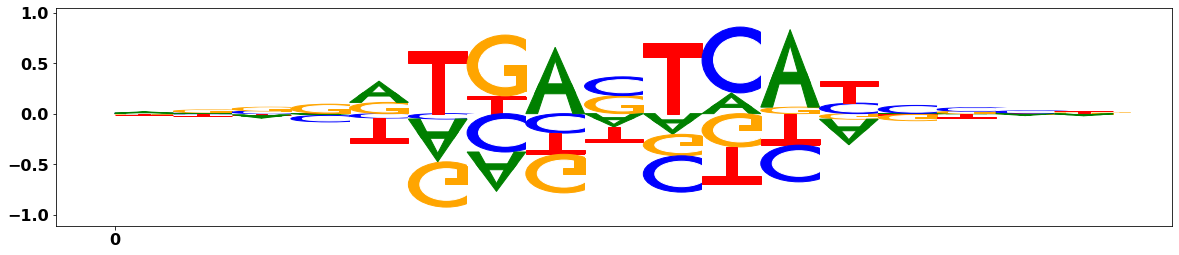

<table><tr><td>Observed profiles</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAGwCAYAAABfOcJAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg%2BJYAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOy9eZjsRn3u/0rqVves5xzbx8YbtjE2NjZgY7MYBzBrCISdhISQEMIly00gbEkIv0sC92YjIeESkkDIvtwASTAkEPY1mMVgY8AYjPfjs%2B/nzJyZ6VZLqt8fUklVpVK3uqe7p/vM%2B3me88yZHrVUKpVKVW%2B9%2Bn4dIQQIIYQQQgghhBBCCCGEkGHjbnQBCCGEEEIIIYQQQgghhJycUIAmhBBCCCGEEEIIIYQQMhIoQBNCCCGEEEIIIYQQQggZCRSgCSGEEEIIIYQQQgghhIwECtCEEEIIIYQQQgghhBBCRgIFaEIIIYQQQgghhBBCCCEjgQI0IYQQQgghhBBCCCGEkJFAAZoQQgghhBBCCCGEEELISKAATQghhBBCCCGEEEIIIWQkUIAmhBBCCCGEEEIIIYQQMhJqG12Aqpx22mni/PPP3%2BhiEEIIIYQQQgghhBBCyKbm5ptvPiSE2F5l26kRoM8//3zcdNNNG10MQgghhBBCCCGEEEII2dQ4jrOj6rYMwUEIIYQQQgghhBBCCCFkJFCAJoQQQgghhBBCCCGEEDISKEATQgghhBBCCCGEEEIIGQkUoAkhhBBCCCGEEEIIIYSMBArQhBBCCCGEEEIIIYQQQkYCBWhCCCGEEEIIIYQQQgghI4ECNCGEEEIIIYQQQgghhJCRQAGaEEIIIYQQQgghhBBCyEigAE0IIYQQQgghhBBCCCFkJFCAJoQQQgghhBBCCCGEEDISKEATQgghhBBCCCGEEEIIGQkUoAkhhBBCCCGEEEIIIYSMBArQhBBCCCGEEEIIIYQQQkYCBWhCCCGEEEIIIYQQQgghI4ECNCGEEEIIIYSMgf1HQqysxRtdDEIIIYSQsUIBmhBCCCGEEELGwK%2B/6wD%2B8WPHN7oYhBBCCCFjhQI0IYQQQgghhIyBE6sxHdCEEEII2XRQgCaEEEIIIYSQMSAEEIuNLgUhhBBCyHihAE0IIYQQQgghYyAWQEwDNCGEEEI2GRSgCSGEEEIIIWQMJA5oWqAJIYQQsrmgAE0IIYQQQgghYyAWAtSfCSGEELLZoABNCCGEEEIIIWOAMaAJIYQQshmhAE0IIYQQQgghY0AwBjQhhBBCNiEUoAkhhBBCCCFkDAgBCMbgIIQQQsgmgwI0IYQQQgghhIyBmA5oQgghhGxCKEATQgghhBBCyBgQQjAGNCGEEEI2HRSgCSGEEEIIIWQMxDEQU4EmhBBCyCaDAjQhhBBCCCGEjIEkBvRGl4IQQgghZLxQgCaEEEIIIYSQMSBAAZoQQgghmw8K0IQQQgghhBAyYoQQEAKImISQEEIIIZsMCtCEEEIIIYQQMmKk81nQAk0IIYSQTQYFaEIIIYQQQggZMVJ3Zg5CQgghhGw2KEATQgghhBBCyIiRwnPMEByEEEII2WRQgCaEEEIIIYSQEZOH4NjYchBCCCGEjBsK0IQQQgghhBAyYmTs55gKNCGEEEI2GRSgCSGEEEIIIWTExHRAE0IIIWSTQgGaEEIIIYQQQkaMFJ4jxoAmhBBCyCaDAjQhhBBCCCGEjBg6oAkhhBCyWaEATQghhBBCCCEjRgrPjAFNCCGEkM0GBWhCCCGEEEIIGTFxaoGOGYKDEEIIIZsMCtCEEEIIIYQQMiZogCaEEELIZoMCNCGEEEIIIYSMmFjoPwkhhBBCNgsUoAkhhBBCCCFkxIhY/qQCTQghhJDNBQVoQgghhBBCCBkxMvkg9WdCCCGEbDYoQBNCCCGEEELIiBEMwUEIIYSQTcqGCNCO4yw4jrPTcRyR/rtpI8pBCCGEEEIIIeNACs8MwUEIIYSQzcZGOaB/H8A5G3RsQgghhBBCCBkr0gEdUX8mhBBCyCZj7AK04ziPBfBLAFbGfWxCCCGEEEII2QhE5oDe2HIQQgghhIybsQrQjuPUAfxVetz/Nc5jE0IIIYQQQshGwSSEhBBCCNmsjNsB/esALgdwPYAPj/nYhBBCCCGEELIhZA5oQQWaEEIIIZuLsQnQjuNchMT1fBzAr4zruIQQQgghhBBSxnfuauEVv7MX7WC0sTGk8zmewhAcR5YivPS392Dn/k7hb7/93oO4/vPLQz3eTd9fw8///l6EDJhdma/ftoZf%2BP29iFhnhBBCJpBxOqD/EkATwK8LIfZW%2BYLjOD/vOM5NjuPcdPDgwdGWjhBCCCGEELLpuHd3B/fu6WB5dbTKsIz9PI0hOHYf6GDPwdAqQH/3njZu39Ee6vHu3dPBXTs7WG1NoVq/Qdy9u4M7d3bQCqawgRFCCDnpGYsA7TjOUwA8CcAdAL7hOM4VAB6qbDLjOM4VjuOcon5PCPFeIcTVQoirt2/fPo6iEkIIIYQQQjYRkRSGR6x1SllwGiNwtDtp/GpLHUUREHSGe1LjuiYnE9ItPo0LHIQQQk5%2BamM6zkL682IA37T8/aEAbgHwcgB/P6YyEUIIIYQQQjY540oOKGM/x1OoEGYCtKXoUSTQHrLrVkxxuJKNQobemMb2RQgh5ORn3EkICSGEEEIIIWRikCLnqJ3J8RSH4AhSgdlWR2GUC9TDQqSVFE2jXXyDiKLkJ6uMEELIJDIWB7QQ4sMAHPUzx3HOB3Bv%2BuvNQoirx1EWQgghhBBCCJHkwvBolTu5%2B2kUCPMQHMXCh5EYegiOaU7YuFEwBAchhJBJhg5oQgghhBBCyKZFiqqjFjszUXUKBUIZYsMsuxACUYyhJ76jAN0/edzsKWxghBBCTnrGFQO6gBDiPhiuaEIIIYQQQggZJ9GYQnCcDDGgzTqSAvHQHdAyBMcU1tVGIR3Q0%2BiwJ4QQcvJDBzQhhBBCCCFk0yJFztEnIcRYjjMKypIQSvGeSQg3nmiKY4wTQgg5%2BaEATQghhBBCCNm05OEeGAO6DJmE0Kwj6boddhJCKTzTAV2dSMaApmhPCCFkAqEATQghhBBCCNm0xGMKwRErArSYMhW6LARHNKoQHHRA9000pmSahBBCyCBQgCaEEEIIIYRsWuIxh%2BAYx7GGTVkIDtUBPUxRPYuXPWX1tJEwBjQhhJBJhgI0IYQQQgghZNMyriSEqjN12kRC6XAuC8EhBNAJh3e8cYVFOZkIo%2BQnq4wQQsgkQgGaEEIIIYQQsmmRgt2o4w1rDugpCy3RCuyO5CjK/z/MONCyfqatnjYSxoAmhBAyyVCAJoQQQgghhGxapMt21K5kPQTHdNlU20GiahZiQEeisM0wyBcFhrbLk57cjT5dbYsQQsjmgAI0IYQQQgghZNMyLret6h4WUyas5iE49M9VgXiYDug8BjTF1KrQNU4IIWSSoQBNCCGEEEII2bRkwt2Ixc6TIwmhPQY0kIvUw4Biav/IazFtbYsQQsjmgAI0IYQQQgghZNMSpaLqqF3JakK9aRMJpQBdCMGhOqCDIQrQWRLCoe3ypGdcyTQJIYSQQaAATQghhBBCCNm05A7o0R5HT0I4XSphENhDcKgO6OGG4Eh%2Bjjox5MlE5oBmnRFCCJlAKEATQgghhBBCNi3xmJyj6u6nzaXa6tjDO0RR/v/hOqAZTqJfwvRaTFvbIoQQsjmgAE0IIYQQQgjZtEjH6KjdtmqIj2kTVqUDWhgFj0bkgGYM6P6Jsna8wQUhhBBCLFCAJoQQQgghhGxapIY6aueomsBv2sIktEsc0KEidg4zCaGsqmmrp40kyhzQrDNCCCGTBwVoQgghhBBC

<table><tr><td>Observed profiles</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAGwCAYAAABfOcJAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg%2BJYAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOy9d7ztRmHtv0ba9ZRb3K57wQZsbEwz1UBo6YWQX0gCj4QQSEIapDwgySOUEPLS60shpIdQQifU0DsGG5te3O177dvbKbtJmt8f0oxmRmVr11Pu%2Bn4%2B93Pu2UdbGo1GI2nN0hohpQQhhBBCCCGEEEIIIYQQMm28jS4AIYQQQgghhBBCCCGEkO0JBWhCCCGEEEIIIYQQQgghM4ECNCGEEEIIIYQQQgghhJCZQAGaEEIIIYQQQgghhBBCyEygAE0IIYQQQgghhBBCCCFkJlCAJoQQQgghhBBCCCGEEDITKEATQgghhBBCCCGEEEIImQkUoAkhhBBCCCGEEEIIIYTMBArQhBBCCCGEEEIIIYQQQmYCBWhCCCGEEEIIIYQQQgghM6G20QWoyhlnnCEvvvjijS4GIYQQQgghhBBCCCGEnNLccMMNh6WUZ1ZZdssI0BdffDGuv/76jS4GIYQQQgghhBBCCCGEnNIIIe6suiwjOAghhBBCCCGEEEIIIYTMBArQhBBCCCGEEEIIIYQQQmYCBWhCCCGEEEIIIYQQQgghM4ECNCGEEEIIIYQQQgghhJCZQAGaEEIIIYQQQgghhBBCyEygAE0IIYQQQgghhBBCCCFkJlCAJoQQQgghhBBCCCGEEDITKEATQgghhBBCCCGEEEIImQkUoAkhhBBCCCGEEEIIIYTMhLkK0EKIa4QQbxZC7BdC9IUQB4UQHxVCfM88y0EIIYQQQgghhBBCCCFk9sxNgBZC/CSAzwH4UQB7ANQBnAngCQAeO69yEEIIIYQQQgghhBBCCJkPtXlsRAhxPwCvBeADuBvALwL4BIAmgGsARPMoByGEEEIIIYQQQgghhJD5MRcBGsALEIvNAPAcKeWHjb%2B9b05lIIQQQgghhBBCCCGEEDJH5hXB8eTk5wDAdwkhbhdC9IQQ3xBC/LIQQsypHIQQQgghhBBCCCGEEELmxLwE6AuTn3UALwZwMYAGgMsB/DWAP5hTOQghhBBCyCnO/iMB1rv5CXBRJHHHvYM5l4gQQgghhJDty7wE6Lrx//cBOA1x9vNq8tlvCCHOcr8khPg5IcT1QojrDx06NIdiEkIIIYSQ7c5v/MUBvP4DJ3P/9vmvdfHc37sXh44Hcy4VIYQQQggh25N5CdCHjf//vZTymJTyBgAfSj7zAVztfklK%2BQ9SymuklNeceeaZ8ygnIYQQQgjZ5qysR1hdz3dAn1yPICWw3pFzLhUhhBBCCCHbk3kJ0DdUWGZ95qUghBBCCCGnPFLG//KIovgPlJ8JIYQQQgiZDvMSoP/N%2BP/PCyF2CyEeBuApyWfHAHxxTmUhhBBCCCGnMJEEogIFWn0sixRqQgghhBBCyEjMRYCWUr4FwFuTX78PwFEA1wNYQmww%2BVUpZXceZSGEEEIIIac2ZQ7oMEnmiPITOgghhBBCCCEjMi8HNAA8A8BLAHwDQB/ASQAfBPCdUsp/n2M5CCGEEELIKUwYSS00u%2BgIDhqgCSGEEEIImQq1eW1ISjkA8EfJP0IIIYQQQjaEMge0%2BjyiAE0IIYQQQshUmKcDmhBCCCGEkA2nLAO6yBlNCCGEEEIIGQ8K0IQQQggh5JSizAGthOmIFmhCCCGEEEKmAgVoQgghhBByyiClhJTFERtq8kFmQBNCCCGEEDIdKEATQgghhJBTBiU8R0WTEDIDmhBCCCGEkKlCAZoQQgghhJwyKGezLLA4q%2BgNOqAJIYQQQgiZDhSgCSGEEELIKYNyPhc6oNXfqUATQgghhBAyFShAE0IIIYSQUwblfC6ehBClfyeEEEIIIYSMBgVoQgghhBByyjAs45kRHIQQQgghhEwXCtCEEEIIIeSUIY3gKMiA5iSEhBBCCCGETBUK0IQQQggh5JRBDonYUAI1HdCEEEIIIYRMBwrQhBBCCCHklEFNLjgsgqPIIU0IIYQQQggZDQrQhBBCCCHklGGoA5qTEBJCCCGEEDJVKEATQgghhJBThjTjuSADWkVwzKk8hBBCCCGEbHcoQBNCCCGEkFOGdBLCor/H0rMs%2BDshhBBCCCFkNChAE0IIIYSQU4ZhGdDhEIc0IYQQQgghZDQoQBNCCCGEkFMG5Wwu0peH/Z0QQgghhBAyGhSgCSGEEELIKYPOgC6wQKcZ0XMqECGEEEIIIdscCtCEEEIIIeSUQTmbixzOOgOaAjQhhBBCCCFTgQI0IYQQQgg5ZVACc9EkhCEjOAghhBBCCJkqFKAJIYQQQsgpQzRkksHUIU0FmhBCCCGEkGlAAZoQQgghhJwyVI3gYAY0IYQQQggh04ECNCGEEEIIOWUYNslgOESgJoQQQgghhIwGBWhCCCGEEFLKuz%2B1in985/GNLsZUUNEaxQ5o%2BychhBBCCCFkMihAE0IIIYSQUj7/tQ4%2BddP6RhdjKqQCc1EGtLR%2BEkIIIYQQQiaDAjQhhBBCCCkljLZPJvLQCI5EoN4mu0sIIYQQQsiGQwGaEEIIIYSUEkVy2wjQwychTH5uk/0lhBBCCCFko6EATQghhBBCSgmj4siKrYbaj6LdUX%2BXzIAmhBBCCCFkKlCAJoQQQgghpYSR3DaT8mkHdGEGdPxzm%2BjthBBCCCGEbDgUoAkhhBBCSCnRNsqAVhnP4bAMaE5CSAghhBBCyFSgAE0IIYQQQkrZThEcSlguitiIZHlEByGEEEIIIWQ0KEATQgghhJBSwnD7RHBEQyI29H5SgCaEEEIIIWQqUIAmhBBCCCGlbKcIDp0BXRCxMUygJoQQQgghhIwGBWhCCCGEEFJKPAnh9lBkIy1AF/w9WYAR0IQQQgghhEwHCtCEEEIIIaSUcBs5oJXAHBZlQCefR1SgCSGEEEIImQoUoAkhhBBCSClRtH0yoOVQB3T53wkhhBBCCCGjQQGaEEIIIYSUEkZxDMd2IM14LsqAjj/fLoI7IYQQQgghGw0FaEIIIYQQUkoYym3jCJZDHM46I3o%2BxSGEEEIIIWTbQwGaEEIIIYSUEsrt4wjWDmdGcBBCCCGEEDIXKEATQgghhJBSwjAWbOU2UGX1JIOFkxDG%2Byi3SeQIIYQQQgghGw0FaEIIIYQQUooSZbeDJqsjNgozoO2fhBBCCCGEkMmgAE0IIYQQQkoJt1EshdqHYge0vRwhhBBCCCFkMihAE0IIIYSQUkLlgN4GOdDK%2BVw4CeE2cnsTQgghhBCyGaAATQghhBBCSlEO6HAbqLLDIjbCIREdhBBCCCGEkNGgAE0IIYQQQkoZNnHfVsLUlfNEZskIDkIIIYQQQqYKBWhCCCGEEFJKGJbHVmwlQkNEzxPUOQkhIYQQQggh04UCNCGEEEIIKUWJsdshgsN0PeftjsqA3g5iOyGEEEIIIZuBDRGghRDLQoi7hRAy%2BXf9RpSDEEIIIYSUE0VSi7HbQH%2B29iFPZKYDmhBCCCGEkOmyUQ7o/wvg/A3aNiGEEEIIqciwyIqthjT3J0eBVvsoqUATQgghhBAyFeYuQAshHgXgFwCszXvbhBBCCCFkNKLIjKzY%2BqKs5YDOy4BWERxzKg8hhBBCCCHbnbkK0EKIOoDXJtt96Ty3TQghhBBCRme7OaBNQT3MUZnVZ9tAayeEEEIIIWRTMG8H9IsBXAXgbQDeMedtE0IIIYSQEdluArQckgGtXNFM4CCEEEIIIWQ6zE2AFkLcF7Hr%2BQSAX57Xdgkh

<table><tr><td>Observed profiles</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAGwCAYAAABfOcJAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg%2BJYAAAACXBIWXMAAAsTAAALEwEAmpwYAADsoklEQVR4nOy9d7jsSH3m/5bU8aR7597JeYYwzDDDADOYnJPBYAYwGEx2ABPXOWLjuM5p12Ftr/Gud9c/p/VibIzBYBOMMWaGZIY48c7NOZzQQVL9/ihVVEmt7lanc76f57nPuaePWipJpZL01ltvMc45CIIgCIIgCIIgCIIgCIIgCKJqglkXgCAIgiAIgiAIgiAIgiAIgtiekABNEARBEARBEARBEARBEARBTAQSoAmCIAiCIAiCIAiCIAiCIIiJQAI0QRAEQRAEQRAEQRAEQRAEMRFIgCYIgiAIgiAIgiAIgiAIgiAmAgnQBEEQBEEQBEEQBEEQBEEQxEQgAZogCIIgCIIgCIIgCIIgCIKYCCRAEwRBEARBEARBEARBEARBEBOBBGiCIAiCIAiCIAiCIAiCIAhiIpAATRAEQRAEQRAEQRAEQRAEQUyE2qwLUJbzzz%2BfX3311bMuBkEQBEEQBEEQBEEQBEEQxI7mjjvuOM45v6DMsgsjQF999dW4/fbbZ10MgiAIgiAIgiAIgiAIgiCIHQ1j7P6yy1IEB0EQBEEQBEEQBEEQBEEQBDERSIAmCIIgCIIgCIIgCIIgCIIgJgIJ0ARBEARBEARBEARBEARBEMREIAGaIAiCIAiCIAiCIAiCIAiCmAgkQBMEQRAEQRAEQRAEQRAEQRATgQRogiAIgiAIgiAIgiAIgiAIYiKQAE0QBEEQBEEQBEEQBEEQBEFMBBKgCYIgCIIgCIIgCIIgCIIgiIlAAjRBEARBEARBEARBEARBEAQxEWYiQDPGVhljDzDGePrv9lmUgyAIgiAIgiAIgiAIgiAIgpgcs3JA/wKAy2e0bYIgCIIgCIIgCIIgCIIgCGIKTF2AZow9DsCbAWxMe9sEQRAEQRAEQRAEQRAEQRDE9JiqAM0YqwP4w3S775zmtgmCIAiCIAiCIAiCIAiCIIjpMm0H9A8BuBHAXwN4z5S3TRAEQRAEQRAEQRAEQRAEQUyRqQnQjLGHQLiezwB427S2SxAEQRAEQRA7kWOnIqxvJrMuBkEQBEEQBLHDmaYD%2BvcBtAD8EOf8UJkvMMbeyBi7nTF2%2B7FjxyZbOoIgCIIgCILYRvz47x3DH/3t6VkXgyAIgiAIgtjhTEWAZow9E8DTAXwNwKcZY48EcIOxSJsx9kjG2B7ze5zzP%2BCc38o5v/WCCy6YRlEJgiAIgiAIYltwdjPBBjmgCYIgCIIgiBlTm9J2VtOfDwXwGc/fbwDwWQBvAPA/plQmgiAIgiAIgti2xDEQ81mXgiAIgiAIgtjpTHsSQoIgCIIgCIIgpkDCOTgZoAmCIAiCIIgZMxUHNOf8PQCY%2BRlj7GoA96a/3sE5v3UaZSEIgiAIgiCInUCSCBGaIAiCIAiCIGYJOaAJgiAIgiAIYhsSxxwxOaAJgiAIgiCIGTOtDOgMnPP74LiiCYIgCIIgCIKohoQDZIAmCIIgCIIgZg05oAmCIAiCIAhiGxLHQJKQAk0QBEEQBEHMFhKgCYIgCIIgCGIbknAO0p8JgiAIgiCIWUMCNEEQBEEQBEFsQ%2BJETERIEARBEARBELOEBGiCIAiCIAiC2GZwzpEklAFNEARBEARBzB4SoAmCIAiCIAhimyGjN2LK4CAIgiAIgiBmDAnQBEEQBEEQBLHNkNEb5IAmCIIgCIIgZg0J0ARBEARBEASxzZDOZ8qAJgiCIAiCIGYNCdAEQRAEQRAEsc2QwnNCFmiCIAiCIAhixpAATRAEQRAEQRDbDCVAkwOaIAiCIAiCmDEkQBMEQRAEQRDENkNFcJABmiAIgiAIgpgxJEATBEEQBEEQxDYjVg5oUqAJgiAIgiCI2UICNEEQBEEQBEFsM6QDmiKgCYIgCIIgiFlDAjRBEARBEARBbDMoA5ogCIIgCIKYF0iAJgiCIAiCIIhthhKgyQFNEARBEARBzBgSoAmCIAiCIAhim6EmISQFmiAIgiAIgpgxJEATBEEQBEEQxDaDHNAEQRAEQRDEvEACNEEQBEEQBEFsM5QDmgRogiAIgiAIYsaQAE0QBEEQBEEQ2wzpgOakQBMEQRAEQRAzhgRogiAIgiAIgthmxKkAHZP%2BTBAEQRAEQcwYEqAJgiAIgiAIYpshJx/kyYwLQhAEQRAEQex4SIAmCIIgCIIgiG1GTJMQEgRBEARBEHMCCdAEQRAEQRAEsc2QDuiEFGiCIAiCIAhixpAATRAEQRAEQRDbDHJAEwRBEARBEPMCCdAEQRAEQRAEsc1IEvsnQRAEQRAEQcwKEqAJgiAIgiBmQD/iWN8iddDl4PEIX3%2Bgh35UbN09uxEjzrH3xjHHuU19bDu9BFvdcseac44z63H5Ao/ImfV4rHiMbi/BVid/n%2BSxSThZoEdhWvWAqI7NToJubzJt6rjXK0EQBEHsdEiAJgiCIAiCmAF/%2BoGzeNsvH551MeaKoycjvPonD%2BJNv3AY737v6dzlOr0Er3znQXzkjk3v3//uE%2Bt47U8dVILRb/3ZKfz0fz9eqgyf%2BWoXL/vRAzh5ZnLi4/pmgm/98YP45H9sjbyO3/rzU/ipgn2KyQE9Frd/uYOX/egBnDpHIvSi8BO/fwy/81enK1/vxlaCV/z4QfzL50e/XgmCIAhip0MCNEEQBEEQxAw4eSbGiQmKnIvI6XWtlpoOZpdOl2Ory3HyrP/4nTwT48x6ovKPTwxxrI%2BfjhDFwJmNCQrQWwl6fT7W%2BT95JsaJ0/nfl%2BI7GaBH4/iZGFEMnNsgBX9ROHpyMm3qxlaCbp/j6Kmo8nUTBEEQxE6BBGiCIAiCIIgZEHOOiPRni44xfD4u0P2kqzdvGTf/OEnKH2u53CTPjRTGxxnRHydAFOevQB8jUqBHIU7PPx2/xaHT4xOJyZCr7PaoLhAEQRDEqJAATRAEQRAEMQPiuFhA3Il0uvp4FAl/Kt845/jJv8fp3%2BNE/38Q8pxM8tyoco2xjTjhiApEeinOkwN6NOT5pwiTxaHbSwo7rkZFXqcdEqAJgiAIYmRIgCYIgiAIgpgBScIRJ2KyM0JgCjxFwp8UmfL0W/fvyQC3sPXd2P45CZQze4xTP2ifpBOUBNTRiIzOC2IxmJQDWl5mJEATBEEQxOiQAE0QBEEQBDEDpE5CApdGDnEPgwERHIawXPx3KSIOE8ExeQd0wscXNxNeLJLHFYjcOxlZXyYhaBLVE8XiGp9Eh4tcJ0VwEARBEMTokABNEARBEAQxA2KVNUyihqTbF8diuR0UCn86WiMngsNxr85fBIf4mRchUm4dvJQD2v0/UQ63DhHzjRSHJxvBQZWBIAiCIEaFBGiCIAiCIIgZIF2wNBGhRgo87SYrdDK6kwwO%2BvswkxDGU5yEcByNe1AEh/knSnkZHnJALxZagKZJCAmCIAhiHiEBmiAIgiAIYgborGESNSRS4FlqBYVCkoqwGDAJoY7gKO9ojiqYIHAQcQUT3MUJL47giM1lR9/OToUyoBeLTn/yDmgSoAmCIAhidEiAJgiCIAiCmAFSJCUHtKbT4wgCoFEvdkCrCIscPSgxojfk7%2BUFaPvnJNDRIKMLWmUnIQRoostRqKKTgJge3XT0xCQc63KVNAkhQRAEQYwOCdAEQRAEQRAzQIoalAGt6fY4Wg1WehLCvGX037UTusgtbDLNSQjHckBzIZLnicumDkci6vDIDohJRDoQ1SPF4UmcLpqEkCAI

<h4>Pattern 2/2</h4>

<p>73 seqlets</p>

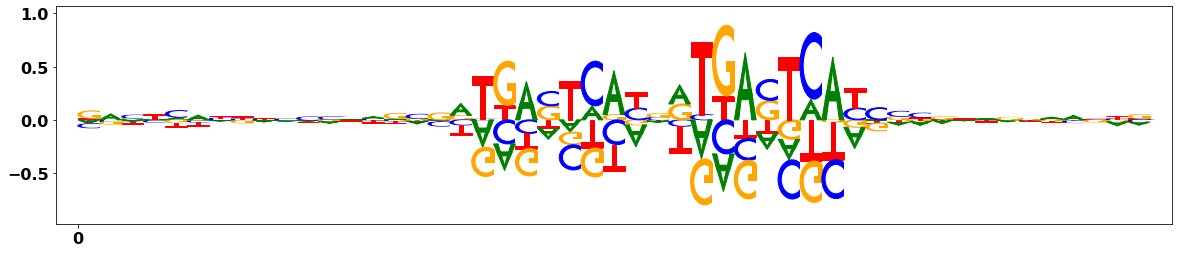

<table><tr><td>Observed profiles</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAGwCAYAAABfOcJAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg%2BJYAAAACXBIWXMAAAsTAAALEwEAmpwYAADcUklEQVR4nOz9eZjkyEHmj78h5VFVXdV39/TMtOc0tvGFPR7b7QPMYRsM%2BMdtdr8s17L4y7JcC3yBNSzLsRgWWLPcYDCwHAaMucxhg8E2Psbn%2BL4999hzd0%2BfVZWZkuL3hxShiFAoU5mpzFRmvZ/n6aey85BCUigUeuPVG0JKCUIIIYQQQgghhBBCCCGkboJFF4AQQgghhBBCCCGEEELIakIBmhBCCCGEEEIIIYQQQshMoABNCCGEEEIIIYQQQgghZCZQgCaEEEIIIYQQQgghhBAyEyhAE0IIIYQQQgghhBBCCJkJFKAJIYQQQgghhBBCCCGEzAQK0IQQQgghhBBCCCGEEEJmAgVoQgghhBBCCCGEEEIIITOBAjQhhBBCCCGEEEIIIYSQmUABmhBCCCGEEEIIIYQQQshMaC26AFU5evSovOaaaxZdDEIIIYQQQgghhBBCCNnT3HzzzQ9JKY9V%2Be7SCNDXXHMN3vOe9yy6GIQQQgghhBBCCCGEELKnEULcWfW7jOAghBBCCCGEEEIIIYQQMhMoQBNCCCGEEEIIIYQQQgiZCRSgCSGEEEIIIYQQQgghhMwECtCEEEIIIYQQQgghhBBCZgIFaEIIIYQQQgghhBBCCCEzgQI0IYQQQgghhBBCCCGEkJlAAZoQQgghhBBCCCGEEELITKAATQghhBBCCCGEEEIIIWQmUIAmhBBCCCGEEEIIIYQQMhMWIkALIbaEEHcLIWT27z2LKAchhBBCCCGEEEIIIYSQ2bEoB/TPAji5oHUTQgghhBBCCCGEEEIImQNzF6CFEKcA/GcAl%2Ba9bkIIIYQQQgghhBBCCCHzY64CtBCiDeB3svX%2B2DzXTQghhBBCCCGEEEIIIWS%2BzNsB/UMAHg/grwD8zZzXTQghhBBCCCGEEEIIIWSOzE2AFkJ8FlLX8zkA3zWv9RJCCCGEkHp54EyEi9tJLcu673SEnd16lkUIIYQQQghpHvN0QP82gDUAPySlvLfKD4QQLxZCvEcI8Z4HH3xwtqUjhBBCCCGV%2BG%2B/8SB%2B/%2B/P1rKs7/7F%2B/Gqf71Qy7IIIYQQQgghzWMuArQQ4osAfAGATwJ4txDiSQAea3xlXQjxJCHEYfN3UsqXSylvlFLeeOzYsXkUlRBCCCGEjODCdoKzF%2BtxLV/YTnBxhw5oQgghhBBCVpXWnNazlf19FID3ej5/LID3AfhWAH8wpzIRQgghhJAJkBLo92Uty0oSCZnUsyxCCCGEEEJI85j3JISEEEIIIWTJSaREP6pJgJbpP0IIIYQQQshqMhcHtJTybwAI8z0hxDUAbs/%2Be7OU8sZ5lIUQQgghhEyHTID%2BoC4HdOqoJoQQQgghhKwmdEATQgghhJCxSGQ9AnSSWZ/pgCaEEEIIIWR1mVcGdAEp5R1wXNGEEEIIIaT5SAn0ahCglfOZDmhCCCGEEEJWFzqgCSGEEELIWCRS1uKAjpN8eYQQQgghhJDVhAI0IYQQQggZCylRyySESniWydSLIoQQQgghhDQUCtCEEEIIIWQsEgkMasmAzpdHCCGEEEIIWU0oQBNCCCGEkLGQST0Z0AkzoAkhhBBCCFl5FjYJISGEEEIIWU4SKREPalhOpkAzA5oQQgghhJDVhQ5oQgghhBAyFlICUQzEU2ZnqAgO6s%2BEEEIIIYSsLhSgCSGEEELIWCjdeTDlRITMgCaEEEIIIWT1oQBNCCGEEELGQjmW%2B1PmQKvoDZlMWyJCCCGEEEJIU6EATQghhBBCKiOl1AL0tBMR5g5oWqAJIYQQQghZVShAE0IIIYSQyphxGdM7oLO/dEATQgghhBCyslCAJoQQQgghlZE1CtBqEkMaoAkhhBBCCFldKEATQgghhJDKmG7lQTTdspTwzEkICSGEEEIIWV0oQBNCCCGEkMpIw67c60%2BXnaHEbEkLNCGEEEIIISsLBWhCCCGEEFIZKwN6Sge0iuCgA5oQQgghhJDVhQI0IYQQQgipTJ0Z0LkDeqrFEEIIIYQQQhoMBWhCCCGEEFKZpEYBWmdAT5fkQQghhBBCCGkwFKAJIYQQQkhlTLdyb1oHtFTLpAWaEEIIIYSQVYUCNCGEEEIIqUxiWKCndUAzA5oQQgghhJDVhwI0IYQQQgipDDOgCSGEEEIIIeNAAZoQQgghhFTGyoCOasqApgBNCCGEEELIykIBmhBCCCGEVMZ0Kw9qiuCgA5oQQgghhJDVhQI0IYQQQgipTGKoxVNPQpiov1SgCSGEEEIIWVUoQBNCCCGEkMrIJH89dQZ09nM6oAkhhBBCCFldKEATQgghhJDKJLVOQigLyySEEEIIIYSsFhSgCSGEEEJIZeqchJAOaEIIIYQQQlYfCtCEEEIIIaQyMplBBjQVaEIIIYQQQlYWCtCEEEIIIaQyM4ngSEZ8kRBCCCGEELK0UIAmhBBCCCGVMc3KA05CSAghhBBCCBkBBWhCCCGEEFKZeh3QxWUSQgghhBBCVgsK0IQQQgghpDJS1pkBnf5eUoEmhBBCCCFkZaEATQghhBBCKmPmNfejeiI4qD8TQgghhBCyulCAJoQQQgghlVEG6HarvggOZkATQgghhBCyulCAJoQQQgjJ6PUTvOgln8E7P7Kz6KIAAF72yjP4hT86vehiWCi38lonmF6AzpTnaR3Qd947wAt/4G48cCaabkFT8tDZCC/8gbtx%2Bz39hZaDEEIIIYSQJkEBmhBCCCEk49KOxENnY3zmgcUKmYq77hvgrvsHiy6GhcqA7nbE9BEc2gE93XLufSjCpR2JBx6Op1rOtDz4cIxLOxL3PNSM%2BkMIIYQQQkgToABNCCGEEJIRa0duMzIhEgnEyejvzZPcAS3Q70%2B3n9S2TeuAVsctjhd73PT2NOyYEUIIIYQQskgoQBNCCCGEZCQNExCTRC5cVHVR2nwdDmjlfJZT7m91vBYt1utIkYbUH0IIIYQQQpoABWhCCCGEkAwlrk7ryK2LRjqgs/KsdQQGUSqST7usafe3Om7xgg%2BcrClShBBCCCGEkFWCAjQhhBBCSIYSMKcRVeskSZonQCtxda2TdiMHU7ig45oEW3W84sVGQCPWQvhiy0EIIYQQQkiToABNCCGEEJLBCI7RJEYEBwD0BlM4oFUEx7QZ0Nnxiha8r5KEERyEEEIIIYS4UIAmhBBCCMmoKxKiLpJk8RPruUhHgO5PIUDXFXnSmAxoXX%2BadcwIIYQQQghZJBSgCSGEEEIy8knkmiEgNjkDel0J0NHky8ojOKYrk4rwWHQGdFKToE4IIYQQQsgqQQGaEEIIISSjeQ5o2TwBWmdAT%2B%2BATmrK3NbZywvOgGYEByGEEEIIIUUoQBNCCCGEZGgHa0MExEQ2OYIj7UZOJ0Dby5x2OQt3QOsM8WYdM0IIIYQQQhYJBWhCCCGEkIy6HLl1EScNjODIdk0dDmglPE%2BrsevlLDoDumEDGIQQQgghhDQBCtCEEEIIIRlNy/CVUi7c1esiM3G1jkkI1bbJKQVbtZxFu8WbVn8IIYQQQghpAhSgCSGEEEIy8giFxZZDkSSLzzV2qTUDWgu20ym2eQTHVIuZmqY56AkhhBBCCGkCFKAJIYQQQjKaJiCmERzNKItCuhEc0RQRHLVlQGcO6KZkQDfrkBFCCCGEELJQKEATQgghhGRoJ21DBMRESkRxGsXRFJS4qiYh7PWniOCoKb

<table><tr><td>Observed profiles</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAGwCAYAAABfOcJAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg%2BJYAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOy9d7zsSGHlf0pSx3tfmBcmDzPDBIYZGGAYMGCiEzjngOPiHFjAZhf/bBzA68CadcD22mt712vjNcbYZAwO2CbHCcDA5BzevDcvv3dvR0n1%2B6NUpVJJ6lb37e7b993z/Xze5757Wy2VpJJUOnXqlJBSghBCCCGEEEIIIYQQQgiZNd5mF4AQQgghhBBCCCGEEELImQkFaEIIIYQQQgghhBBCCCFzgQI0IYQQQgghhBBCCCGEkLlAAZoQQgghhBBCCCGEEELIXKAATQghhBBCCCGEEEIIIWQuUIAmhBBCCCGEEEIIIYQQMhcoQBNCCCGEEEIIIYQQQgiZCxSgCSGEEEIIIYQQQgghhMwFCtCEEEIIIYQQQgghhBBC5gIFaEIIIYQQQgghhBBCCCFzIdjsAlRl37598pJLLtnsYhBCCCGEEEIIIYQQQsi25sYbbzwipdxfZdktI0BfcskluOGGGza7GIQQQgghhBBCCCGEELKtEUI8UHVZRnAQQgghhBBCCCGEEEIImQsUoAkhhBBCCCGEEEIIIYTMBQrQhBBCCCGEEEIIIYQQQuYCBWhCCCGEEEIIIYQQQgghc4ECNCGEEEIIIYQQQgghhJC5QAGaEEIIIYQQQgghhBBCyFygAE0IIYQQQgghhBBCCCFkLlCAJoQQQgghhBBCCCGEEDIXKEATQgghhBBCCCGEEEIImQsUoAkhhBBCCCGEEEIIIYTMBQrQhBBCCCGEEEIIIYQQQuYCBWhCCCGEEEIIIYQQQgghc4ECNCGEEEIIIYQQQgghhJC5QAGaEEIIIYQQQgghhBBCyFygAE0IIYQQQsgW5r4DA0gpN7sYhBBCCCGEFEIBmhBCCCGEkC3Ko0dC/MivH8SNt/c2uyiEEEIIIYQUQgGaEEIIIYSQLcpaN05%2B0gFNCCGEEEKWEwrQhBBCCCGEbFHiOBGeGcFBCCGEEEKWFArQhBBCCCGEbFEiZYBGTP2ZEEIIIYQsKRSgCSGEEEII2aLEiQBNAzQhhBBCCFlWKEATQgghhBCyRYkS67MWogkhhBBCCFk2KEATQgghhBCyRUkd0LRAE0IIIYSQ5YQCNCGEEEIIIVsUnf3MDGhCCCGEELKsUIAmhBBCCCFkixJFSnmm/kwIIYQQQpYVCtCEEEIIIYRsUUwEBzOgCSGEEELIkkIBmhBCCCGEkC1KlGQ/M4KDEEIIIYQsKxSgCSGEEEII2aJwEkJCCCGEELLsUIAmhBBCCCFki6IFaDqgCSGEEELIskIBmhBCCCGEkC1KpJVnCtCEEEIIIWRJoQBNCCGEEELIFoUOaEIIIYQQsuxQgCaEEEIIIWSLEifKMyOgCSGEEELIskIBmhBCCCGEkC1KlAjPMRVoQgghhBCypFCAJoQQQgghZIsSReon9WdCCCGEELKsUIAmhBBCCCFki6IjOHQWNCGEEEIIIcsGBWhCCCGEEEK2KHryQRqgCSGEEELIsrJQAVoIcb0Q4u%2BFEAeFEAMhxGNCiP8QQrxkkeUghBBCCCHkTEA7nxnBQQghhBBClpWFCdBCiB8A8CkA3wHgHAA1APsBvBDAcxdVDkIIIYQQQs4UosQCLWMq0IQQQgghZDkJFrERIcSVAP4cgA/gIQA/DeAjABoArgfA1DpCCCGEEEImJEpa0dSfCSGEEELIsrIQARrAK6DEZgB4mZTy36zPPrCgMhBCCCGEEHJGoSchZAQHIYQQQghZVhYVwfGVyc8hgK8RQtwnhOgLIW4TQrxcCCEWVA5CCCGEEELOGGI6oAkhhBBCyJKzKAH6ccnPGoDXALgEQB3AVQD%2BEMAbFlQOQgghhBBClo7BUOI7f%2BERfOxznYm%2Bp4VnSQs0IYQQQghZUhYlQNes/38AwB6o7Oe15G%2BvFkKc7X5JCPHjQogbhBA3HD58eAHFJIQQQgghZPF0%2BzGOnozw8GPhRN9jBAchhBBCCFl2FiVAH7H%2B/7%2BklMellDcC%2BGDyNx/Ate6XpJR/JqW8Xkp5/f79%2BxdRTkIIIYQQQhaOdjIPw8mU5CjKfp8QQgghhJBlY1EC9I0VlplsvCEhhBBCCCFnCDrLeRhNKECbCI4ZF4gQQgghhJAZsSgB%2Bq%2Bs//%2BEEOIsIcTTAXxV8rfjAG5aUFkIIYQQQghZKnSURjihA1p/jw5oQgghhBCyrCxEgJZS/gOAtye/fh2AYwBuALAKQAJ4lZSyt4iyEEIIIYQQsmxEiQN6MFkEtHFOSyrQhBBCCCFkSVmUAxoAXgrg5wHcBmAA4BSAfwXw1VLKNy%2BwHIQQQgghhCwV0QYd0JSfCSGEEELIshIsakNSyiGA307%2BEUIIIYQQQhJMBvSkkxBqBzQVaEIIIYQQsqQs0gFNCCGEEEIIKWDaSQj195jAQQghhBBClhUK0IQQQgghhGwysdQRHJN9L0q%2BxwxoQgghhBCyrFCAJoQQQgghZJOZNoKDDmhCCCGEELLsUIAmhBBCCCFkk4k2GMHBDGhCCCGEELKsUIAmhBBCCCFkk4kSC/PkkxAmERwUoAkhhBBCyJJCAZoQQgghhJBNRjuZJ82ApgOaEEIIIYQsOxSgCSGEEEII2WRi7YCeMIJDO6BjKtCEEEIIIWRJoQBNCCGEEELIJrPRSQipPxNCCCGEkGWFAjQhhBBCCCGbTGQiOCYUoGX2JyGEEEIIIcsGBWhCCCGEEEI2GR2lMZgwAzqKOAkhIYQQQghZbihAE0IIIYQQssloB/O0DmgK0IQQQgghZFmhAE0IIYQQQsgmo7OcwwknIdTf4ySEhBBCCCFkWaEATQghhBBCyCYTmwiOyYRkHd1B/ZkQQgghhCwrFKAJIYQQQgjZZNJJCCf7XuqAnm15CCGEEEIImRUUoAkhhBBCCNlktAN6OK0DOp55kQghhBBCCJkJFKAJIYQQQgjZZCLLyRxNYGdmBjQhhBBCCFl2KEATQgghhBCyycSWgzmcwAUd0/lMCCGEEEKWHArQhBBCCCGETMkb/uoobritm/v7%2Bz62hr9834nM3/710%2Bv4s3ceL1yP7XoeTpADHSXO5zNBiH7PR07jze8/udnFIIQQQgghM4YCNCGEEEIIIVMgpcS/fHodN97Wy3326S928eGbOpm/febWLv7jxk5uWSArIA%2BjyR3QZ0ICx6cKjhkhhBBCCNn6UIAmhBBCCCFkCnRuc6efV3%2BjWGIYZf8WRuVOZTv2eTisribb2dFbnTCafBJGQgghhBCy/FCAJoQQQgghZAqixKnc7eVVZSnzWc5RJEuF4kwEx0QOaJlsb%2BsLt1EsEU6w74QQQgghZGtAAZoQQgghhJApGOWAjmXezRvFqWCcWz4zCWH1MsRnkAM6iibLvyaEEEIIIVsDCtCEEEIIIYRMgRGgCxzQcVwkQEvznfy67EkIJ3dA40wQoGPJCA5CCCGEkDMQCtCEEEIIIYRMgY6L6BY6oGXOzRtFWaE5s/yUkxDqRc8EBzQzoAkhhBBCzkwoQBNCCCGEEDIFozKg4zgvJEeRLJ%2BE0BagJxBho2SiwzMgApoZ0IQQQgghZygUoAkhhBBCCJmCcRnQcZx1PKsM6OJ12dnQE2VAJ8pzfAYo0HGSAX0mTKhICCGEEEJSKEATQgghhBAyBVqALnZAKxE1DG0BWpYKxbbxd5IIDi1oyxJheyuhxfow2uSCEEIIIYSQmUIBmh

<table><tr><td>Observed profiles</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAGwCAYAAABfOcJAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg%2BJYAAAACXBIWXMAAAsTAAALEwEAmpwYAACWVElEQVR4nO39eZw0WVnnf39PZGRW1b3fvTe90yzdNCJKs8yAwAgyMygo7s64wKOD%2Big67suM2%2BjjuIyjqDOj%2BBsH9RkHFWVRcQEZEAGFBhQBQWm6m256odd7rcol4vz%2BiDgnTkRGZGVV5VKV8Xm/Xt11V66RkRGZlVdc%2Bb2MtVYAAAAAAAAAAMxatOwFAAAAAAAAAACsJgrQAAAAAAAAAIC5oAANAAAAAAAAAJgLCtAAAAAAAAAAgLmgAA0AAAAAAAAAmAsK0AAAAAAAAACAuaAADQAAAAAAAACYCwrQAAAAAAAAAIC5oAANAAAAAAAAAJgLCtAAAAAAAAAAgLmIl70A07rooovstddeu%2BzFAAAAAAAAAIBWe9/73veAtfbiaS57YArQ1157rW655ZZlLwYAAAAAAAAAtJox5o5pL0sEBwAAAAAAAABgLihAAwAAAAAAAADmggI0AAAAAAAAAGAuKEADAAAAAAAAAOaCAjQAAAAAAAAAYC4oQAMAAAAAAAAA5oICNAAAAAAAAABgLihAAwAAAAAAAADmggI0AAAAAAAAAGAuKEADAAAAAAAAAOaCAjQAAAAAAAAAYC4oQAMAAAAAAAAA5oICNAAAAAAAAABgLihAAwAAAAAAAADmggI0AAAAAOTOnk/16YdGy14MAACAlUEBGgAAAAByr/7jU/r%2B/3b/shcDAABgZVCABgAAAIDc2fOpzpxPl70YAAAAK4MCNAAAAADkrLVKrV32YgAAAKwMCtAAAAAAkLNWSmmABgAAmBkK0AAAAACQSylAAwAAzBQFaAAAAADIZR3QRHAAAADMCgVoAAAAAMilVkqoPwMAAMwMBWgAAAAAyFlrlVCBBgAAmBkK0AAAAACQYwghAADAbFGABgAAAIBcarP/AAAAMBsUoAEAAAAgZ637jyo0AADALFCABgAAAIBcmrc/E8MBAAAwGxSgAQAAACDnGp8TCtAAAAAzQQEaAAAAAHIueCMlggMAAGAmKEADAAAAQM7VnYngAAAAmA0K0AAAAACQc4VnCtAAAACzQQEaAAAAAHI2b4FOUiI4AAAAZoECNAAAAADkXN2Z%2BjMAAMBsUIAGAAAAgBwZ0AAAALNFARoAAAAAckUBmhZoAACAWaAADQAAAAA5V4BO6IAGAACYCQrQAAAAAJBL8wo0DdAAAACzQQEaAAAAAHJEcAAAAMwWBWgAAAAAyKUMIQQAAJgpCtAAAAAAkLN54TmhAxoAAGAmKEADAAAAQM6VnemABgAAmA0K0AAAAACQYwghAADAbFGABgAAAICcG0KYJFSgAQAAZoECNAAAAADkXAY0HdAAAACzQQEaAAAAAHKu8EwGNAAAwGwspQBtjDlqjLnTGGPz/25ZxnIAAAAAQMjmGRwJLdAAAAAzsawO6P8s6col3TcAAAAA1LJ0QAMAAMzUwgvQxphnSPpmSecWfd8AAAAAMImP4KABGgAAYCYWWoA2xnQl/Vp%2Bv/9xkfcNAAAAANspOqCpQAMAAMzCojugv1fSEyX9gaTXL/i%2BAQAAAGAiV3dOiOAAAACYiYUVoI0xj1XW9XxK0rcu6n4BAAAA4H%2B%2B8RG98nce0qmzib7mR%2B7WHfcMJUkf/PiWvv4n7lF/kFWc3RBCOqABAABmY5Ed0L8qaV3S91pr75nmCsaYlxtjbjHG3HL//ffPd%2BkAAAAArKyP3j7QR28b6L6HEn3q/pE%2BeV9WgP7Ep4a67e6hTp/PCtApQwgBAABmaiEFaGPM8yT9C0n/KOm9xpgnS3pCcJENY8yTjTEXhNez1r7KWnuztfbmiy%2B%2BeBGLCgAAAGAFJYlVYq2S1HU4Z6ePkvLvYgghAADATMULup%2Bj%2Bc/HSXp/zflPkPQBSS%2BT9OoFLRMAAACAlkjSrMjsCs0uaiNJst/d6SlDCAEAAGZq0UMIAQAAAGDhRonNC9B5x7MbNpiUM58tQwgBAABmaiEd0Nba10sy4WnGmGsl3Zb/%2Bj5r7c2LWBYAAAAA7TNKsviNogM6Pz3/PfHRG5VIDgAAAOwJHdAAAAAAVp6L4EgqHc5JJQPa%2BigOIjgAAABmYVEZ0GOstber0hUNAAAAAPOQJFZpan3B2WVAj5LifCnMgF74IgIAAKwkOqABAAAArLwk7372BWbfCV0uPIeXBwAAwN5RgAYAAACw8oohhNnv7qfrgPbDCSs/AQAAsDcUoAEAAACsvCTJisqusGyrHdCV4YTUnwEAAGZjaRnQAAAAALAoo9TKpkW0hitEJy4D2g8fzH9PqEADAADMAgVoAAAAACvPFZpdgdl1Oo/88MFyZzQd0AAAALNBARoAAADAyksSK5mg8zkNTtd4BAdDCAEAAGaDDGgAAAAAK2%2BUqDSE0OaV5lFlKKHrhGYIIQAAwGzQAQ0AAABg5WXDBo0vLFeznpPKcMKUDmgAAICZoAANAAAAYKVZazVKJGOskkqBuZoNXf0JAACAvSGCAwAAAMBK88XmtC7ruT4DmggOAACA2aAADQAAAGClJUHOcxHBkWdAuw7oSgQHQwgBAABmgwI0AAAAgJU2Smzw7%2BynKzSPfAZ0MZhQIgMaAABgVihAAwAAAFhpYTezKziHsRxSlvkcpm4QwQEAADAbFKABAAAArLSwA3o4chEc2e%2BJL0hb2bAATf0ZAABgJihAAwAAAFhpSW0ERx694TOgy7EbZEADAADMBgVoAAAAACvNFZ2logPaFZhHadgBHWZA0wINAAAwCxSgAQAAAKy0Ugd0XoC2PoIj/zmWAb2opQMAAFhtFKABAAAArLQwTmPoIjfyYnNpKCEZ0AAAADNHARoAAADAShvVdEC7iI1wCGG5A5oKNAAAwCxQgAYAAACw0kod0NUIjrT4GURAM4QQAABgRihAAwAAAFhpYQf00HU810RwpAwhBAAAmDkK0AAAAABWmhs0KEmjUfbTuggO3wFtSx3Q1J8BAABmgwI0AAAAgJWW1HRAJ7Ud0OF1FrZ4AAAAK40CNAAAAICVNgrynN0QQhtkP0tZ8bncAU0LNAAAwCxQgAYAAACw0kod0NUhhL4D2jKEEAAAYA4oQAMAAABYaeUhhNnPJK82j/Lfx4cQLmzxAAAAVhoFaAAAAAArLWmI4Ai7npPU%2BlgOKTsPAAAAe0cBGgAAAJjS295/Xu/64PllL8bCve5tZ/TR2/szua3/8%2Benddvdg5nc1rTqhhCmtuh%2Bdr%2Bntvy78w%2B39/W6t52Z92ICAACsJArQAAAAwJR%2B9y2n9bq3nV32Yizcr7/xEb35Pef2fDvDkdWvvf4Rvf39iy3ih4Xm0Sj7aW3W9eykaWUIYdAN/ed/c06//oePzHchAQAAVhQFaAAAAGBKaVrupm2LxM4mE7k/LLqPFyksNI%2BCoYNJ2AGdWtmG66QJmdAAAAC7RQEaAAAAmFKaWo1aWIhM09kUYAcDV/zd%2B23tRNgBPRwVRfCwyJykkk3rhxCOEksBGgAAYJcoQAMAAABTStOig7ZN0tQqsXt/3L4DesEt0GHXuitG2x1kQI8Sq3QGjx8AAKCNKEADAAAAU0psSyM4UpXiKnZra5D621ukug7oJLWlgwlpaisZ0OXu6EUvMwAAwKqgAA0AAABMKUnsTAqxB4m1WWF2Fl3Lg6Er/u75pnakLgM6G0JYXCZNy13PSU0Eh6ULGgAA

<h3>Metacluster 2/2</h3>

<h4>Pattern 1/1</h4>

<p>140 seqlets</p>

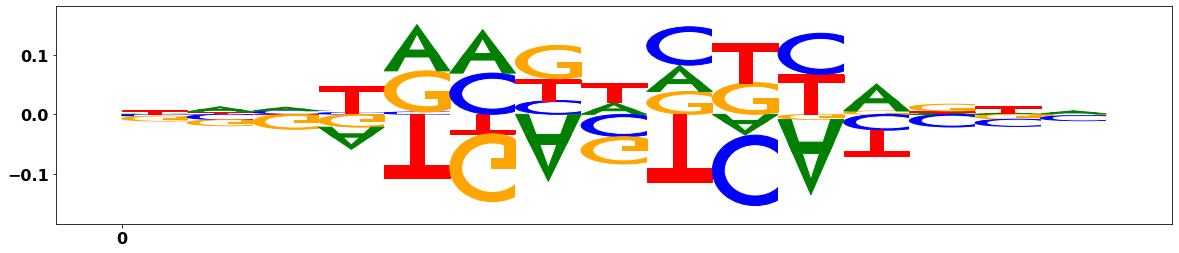

<table><tr><td>Observed profiles</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAGwCAYAAABfOcJAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg%2BJYAAAACXBIWXMAAAsTAAALEwEAmpwYAADWNUlEQVR4nOz9d7gtyV3ei7/V3WuHE%2BacyTMaaTTKo4zQCEQOkgMYA7ZxwCb5RzBO%2BGf7MQ7YwAVsHK4JvrbB8gUDNkIYBBISGBASkpCEJEYaBVDOMxqNJpxJJ%2B29urvuH90Vuzqstbp79Vrr/TzPec7ea/eqrq6qrq7%2B9tvvV0gpQQghhBBCCCGEEEIIIYT0TbTuChBCCCGEEEIIIYQQQgjZThiAJoQQQgghhBBCCCGEEDIIDEATQgghhBBCCCGEEEIIGQQGoAkhhBBCCCGEEEIIIYQMAgPQhBBCCCGEEEIIIYQQQgaBAWhCCCGEEEIIIYQQQgghg8AANCGEEEIIIYQQQgghhJBBYACaEEIIIYQQQgghhBBCyCAwAE0IIYQQQgghhBBCCCFkEBiAJoQQQgghhBBCCCGEEDIIybor0JVrrrlG3nLLLeuuBiGEEEIIIYQQQgghhOw073jHO%2B6XUl7bZduNCUDfcsstuP3229ddDUIIIYQQQgghhBBCCNlphBCf7LotLTgIIYQQQgghhBBCCCGEDAID0IQQQgghhBBCCCGEEEIGgQFoQgghhBBCCCGEEEIIIYPAADQhhBBCCCGEEEIIIYSQQWAAmhBCCCGEEEIIIYQQQsggMABNCCGEEEIIIYQQQgghZBAYgCaEEEIIIYQQQgghhBAyCAxAE0IIIYQQQgghhBBCCBkEBqAJIYQQQgghhBBCCCGEDMIoAWghxAuEEK8UQnxcCHFeCHEshLhbCPHrQogvGKMOhBBCCCGEEEIIIYQQQsZlLAX0MwF8LYBbAJwEMANwI4CvB/BGIcTnjVQPQgghhBBCCCGEEEIIISMxVgD6wwC%2BHcATABwAeAaA28u/JQD%2B%2Bkj1IIQQQgghhBBCCCGEEDISyRg7kVK%2BGcCbrY/eL4T4BQC3lb/Px6gHIYQQQgghhBBCCCGEkPEYJQBtI4RIADwVwLeUHz0K4H%2BMXQ9CCCGEEEIIIYQQQgghwzKWBQcAQAjxCRRq5z9BoX7%2BDIAXSynfN2Y9CCGEEEIIIYRMm4/ffQwpZa9lPnw%2Bw7mHs8HKJ4QQQkiVUQPQAW4E8FtCiOeE/iiE%2BC4hxO1CiNvvu%2B%2B%2BkatGCCGEEEIIIWQdfOb%2BFN/%2BI/fgHR%2B43Gu5P/GyB/GjP/8A7rp3jm//kXvw7g8f9Vo%2BIYQQQqqMGoCWUt4CYA/ArQB%2Btfz4agA/XLP9S6SUt0kpb7v22mvHqSQhhBBCCCGEkLVy4VIOADh/qV%2BF8qMXMpy/lOP8xbL88n9CCCGEDMfoCmgp5VxK%2BUEA/9r6%2BKlj14MQQgghhBBCyDTRYeeeLTLyvChclUoDDkIIIWR4RglACyF%2BXAjxdUKIxwkh9oQQTwTwT61NPjpGPQghhBBCCCGETB8Vd857jhDnEsil1OXTApoQQggZnmSk/fwFAP//mr9dAPB/jVQPQgghhBBCCCETJy8jz30HiHNZlJnn5ndCCCGEDMtYFhz/DcCbAdwLYA7gEoAPlp8/T0r5RyPVgxBCCCGEEELIxNEK6J4tmvNclkHoMsDNCDQhhBAyOKMooKWUPwrgR8fYFyGEEEIIIYSQzSbXFhk9e0ArBfRAFh%2BEEEIIqTJ6EkJCCCGEEEIIIaSJwTyg87JsBp4JIYSQ0WAAmhBCCCGEEELIpNAWGT2Xm%2BcSUkqjgO7Z4oMQQgghVRiAJoQQQgghhBAyKbQFR%2B8e0MaGA%2Bjf4oMQQgghVRiAJoQQQgghhBAyKQaz4NAe0HKQ8gkhhBBShQFoQgghhBBCCCGTYrAkhLn0FNC9Fk8IIYSQAAxAE0IIIYQQQgiZFIMqoHPLA5oBaEIIIWRwGIAmhBBCCCGEEDIpdBLCngPEWV4kNqQCmhBCCBkPBqAJIYQQQgghhEyKoQLEUvoWHIxAE0IIIUOTrLsChBBCCCGEEEKITT5QADrPmYSQEEIIGRsGoAkhhBBCCCGETAqZF//nPUegs9wtnwJoQgghZHgYgCaEEEIIIYQQMinygTygcykhYJTPed5v%2BYQQQgipwgA0IYQQQgghhJBJIQcKEMscgKAHNCGEEDImTEJICCGEEEIIIWRSDJWEUCUgVMUy/EwIIYQMDwPQhBBCCCGEEEImhU5C2HO5WS6LIHQ%2BjMUHIYQQQqowAE0IIYQQQgghZFJoBXTeb4Q4z4uy6QFNCCGEjAcD0IQQQgghhBBCJoXyZu45/lwGn%2BVgFh%2BEEEIIqcIANCGEEEIIIYSQSZEPFCDOcukqoBmBJoQQQgaHAWhCCCGEEEIIIZNC6gBxv%2BXmuUpESA9oQgghZCwYgCaEEEIIIYQQMimMRUbPHtASgAQtOAghhJARYQCaEEIIIYQQQsikGMKCQ0pjv8EANCGEEDIeDEATQgghhBBCCJkUQyQhzC1VdT6QxQchhBBCqjAATQghhBBCCCFkUgyhgM5z8/9QFh%2BEEEIIqcIANCGEEEIIIYSQSSFVsLjXALRJPKh%2BpgKaEEIIGR4GoAkhhBBCCCGETAoVF5Y9Roht2w2tgM57K54QQgghNTAATQghhBBCCCFkUsgBPJpzK9isLT76K54QQgghNTAATQghhBBCCCFkUuQDeGPYRdKCgxBCCBkPBqAJIYQQQgghhEyKYRTQprCsVEP3afFBCCGEkDAMQBNCCCGEEEIImRTaImMAD2jABKAZfyaEEEKGhwFoQgghhBBCCCGTYmgP6CyTzn4IIYQQMhwMQBNCCCGEEEIImRRS9h8gti048gEC3IQQQggJwwA0IYQQQgghhJBJMUSAOLMU0DoYTQk0IYQQMjgMQBNCCCGEEEIImRQ6LtxjfNiONWdZ8T8V0IQQQsjwMABNCCGEEEIIIWRSGAV0j0kIrWhzltMDmhBCCBkLBqAJIYQQQgghhEwKOYBDRmYroEs7DiqgCSGEkOFhAJoQQgghhBBCyKSQZWS4zwBxbnlAqwA0FdCEEELI8DAATQghhBBCCCFkUmgL6F49oE1huQ5wMwJNCCGEDA0D0IQQQgghhBBCJoX2gO5RAh1SQPeZ5JAQQgghYRiAJoQQQgghhBAyKQbxgHYC0P1bfBBCCCEkDAPQhBBCCCGEEEImhVI%2B9xkfttXUWVb8TwcOQgghZHgYgCaEEEIIIYQQMilUYLhPhbIdbNYKaEqgCSGEkMFhAJoQQgghhBBCyKTQSQjzxs0WwrbgUH7QVEATQgghw8MANCGEEEIIIYSQSaECz3mPEWK7LB2A7q10QgghhNTBADQhhBBCCCGEkEmRD5CEMGcSQkIIIWQtMABNCCGEEEIIIWRSSNl/gDh3PKDL/fRo8UEIIYSQMAxAE0IIIYQQQgiZFDpY3KsC2hSWZSrATQk0IYQQMjQMQBNCCCGEEEIImRQqLtyrAtqx4HD3QwghhJDhGCUALYT4GiHEzwsh3i%2BEeFAIcV4I8cdCiH8rhLhqjDoQQgghhBBCCNkMpPaA7jMJofUzPaAJIYSQ0UhG2s/fA/BnvM%2BeWf77K0KI50kpHx6pLoQQQgghhBBCJkw%2BiAJaWj%2BXPzAATQghhAzOWBYcRwD%2BK4DnAzgE8EIAd5V/ewKAbx%2BpHoQQQgghhBBCJo5SPvdpkRGy4KACmhBCCBmesRTQ3ySlfNT6/W1CiJ8E8B/K3586Uj0IIYQQQggh

<table><tr><td>Observed profiles</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAGwCAYAAABfOcJAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg%2BJYAAAACXBIWXMAAAsTAAALEwEAmpwYAACrb0lEQVR4nO3defw8WV3f%2B/ep7v4uv9/M/GaHAWYY9k0RZFDRIIgmer0uMVETTdxiLklu1EQTl8Ro3PUmMa6JisYtCXFhTQRBBWVHGVZBBJFhWGeYffst3%2B6qc/%2BoOlWnqqu7q7tr7X49H4%2BZ3/fb3%2B6uU3vVpz7nc4y1VgAAAAAAAAAA1C3ougEAAAAAAAAAgN1EABoAAAAAAAAA0AgC0AAAAAAAAACARhCABgAAAAAAAAA0ggA0AAAAAAAAAKARBKABAAAAAAAAAI0gAA0AAAAAAAAAaAQBaAAAAAAAAABAIwhAAwAAAAAAAAAaQQAaAAAAAAAAANCIcdcNqOrKK6%2B0119/fdfNAAAAAAAAAIC99ta3vvV2a%2B1VVd47mAD09ddfrxtvvLHrZgAAAAAAAADAXjPG3Fz1vZTgAAAAAAAAAAA0ggA0AAAAAAAAAKARBKABAAAAAAAAAI0gAA0AAAAAAAAAaAQBaAAAAAAAAABAIwhAAwAAAAAAAAAaQQAaAAAAAAAAANAIAtAAAAAAAAAAgEYQgAYAAAAAAAAANKKVALQx5unGmJcaY24yxtxvjDkxxnzcGPNiY8wz2mgDAAAAAAAAAKBdbWVAP0nSl0m6XtJpSRNJ10j625Jea4z5jJbaAQAAAAAAAABoSVsB6L%2BS9M2SHiHpSNITJd2Y/G0s6WtbagcAAAAAAAAAoCXjNiZirX2DpDd4L73XGPObkm5Ifp%2B20Q4AAAAAAAAAQHtaCUD7jDFjSY%2BV9PXJS/dJ%2BrW22wEAAAAAAAAAaFZbJTgkScaYDynOdn6P4uznT0j6AmvtX7TZDgAAAAAAmnTTx09kre26GQAAdK7VAHSJayS93Bjz5LI/GmOea4y50Rhz42233dZy0wAAAAAAWN%2BHPjHVN//ILXrPB0%2B6bgoAAJ1rNQBtrb1e0oGkx0t6QfLyFZJ%2BeMH7n2etvcFae8NVV13VTiMBAAAAANjC/Wej3L8AAOyz1jOgrbVTa%2B37JP2o9/Jj224HAAAAAABNogAHAAAtBaCNMT9ljPlyY8y1xpgDY8wjJX2395a/bqMdAAAAAAA0LUpqP0fUgAYAQOOWpvMVkv7lgr89IOkHW2oHAAAAAACNslH%2BXwAA9llbJTh%2BSdIbJH1S0lTSOUnvS15/qrX2LS21AwAAAACARkU2/y8AAPuslQxoa%2B2PS/rxNqYFAAAAAECXXOUNKnAAANDBIIQAAAAAAOwyW/gXAIB9RgAaAAAAAIAaRUntDUsNDgAACEADAAAAAFAnSw1oAABSBKABAAAAAKhRRA1oAABSBKABAAAAAKgRGdAAAGQIQAMAAAAAUKMoiUBbUqABACAADQAAAABArSjBAQBAigA0AAAAAAA1ogY0AAAZAtAAAAAAANSIGtAAAGQIQAMAAAAAUCMyoAEAyBCABgAAAACgRjaJQEekQAMAQAAaAAAAAIA6kQENAECGADQAAAAAAA0g/gwAAAFoAAAAAABqFUX5fwEA2GcEoAEAAAAAqJFNam9YanAAAEAAGgAAAACAOrka0IxBCAAAAWgAAAAAAGplGYQQAIAUAWgAAAAAAGpEBjQAABkC0AAAAAAA1CjNfCYADQAAAWgAAAAAAOrkBh%2BMqMEBAAABaAAAAAAA6hRRAxoAgBQBaAAAAAAAamSpAQ0AQIoANAAAAAAANYqi%2BF8yoAEAIAANAAAAAECt0hrQpEADAEAAGgAAAACAOhF2BgAgQwAaAAAAAIAaUQMaAIAMAWgAAAAAAGqU1oCOum0HAAB9QAAaAAAAAIAakQENAECGADQAAAAAADWKkgi0G4wQAIB9RgAaAAAAAIAakQENAECGADQAAAAAADVyAWgSoAEAIAANAAAAAECtCEADAJAhAA0AAAAAQI0iSnAAAJAiAA0AAAAAQI0sgxACAJAiAA0AAAAAQI3IgAYAIEMAGgAAAACAGtko/y8AAPuMADQAAAAAADWyhX8BANhnBKABAAAAAKiRK71BCWgAAAhAAwAAAABQK5tEoCMi0AAAEIAGAAAAAKBOaQY0NaABACAADQAAAABAnVzic0QCNAAABKABAAAAAKgTNaABAMgQgAYAAAAAoE5J5NkSgQYAgAA0AAAAAAB1IgMaAIAMAWgAAAAAAGpEDWgAADIEoAEAAAAAqBEZ0AAAZFoJQBtjvsQY8xvGmPcaY%2B4yxtxvjHm3MeYnjDGXt9EGAAAAAADaQAY0AACZcUvT%2BRZJX1h47UnJf19tjHmqtfaeltoCAAAAAEBjIgYhBAAg1VYJjguS/qukp0k6lvRZkj6a/O0Rkr65pXYAAAAAANAsSnAAAJBqKwP6H1pr7/N%2B/1NjzM9I%2Bo/J749tqR0AAAAAADQqogQHAACpVjKgC8Fn58j7%2BSNttAMAAAAAgKZZMqABAEi1VYIjxxhzjeK60JJ0VtJvdtEOABiqv7jpgm69c9Z1MwCs8IZ3ndXJtL/Rh5s%2BfqIPfWK60WdvuWOm937oQs0t2kwYWb327WeptYpW3Pjec7r/bNR1Myp547vO6sJJpFvvnOm9N/Vjf90XUZL6HJECDQBA%2BwFoY8y1kl4t6UGSIknfYK0tzYA2xjzXGHOjMebG2267rc1mAkCv/fB/u12/9Qf3dt0MAEt84vaZvu8Xb9eb/vxc101Z6Od%2B5y794gvv2uizz3/lvfrRX7uj5hZt5p3vv6Af%2BOXb9Vcf2SyYDlR14STS9/z8bXrlm%2B/vuikrffLOmf7dL96uN7zrnJ7/ynv1I796e9dN2itkQAMAkGk1AG2MebykN0h6vKSZpK%2Bz1r5g0futtc%2Bz1t5grb3hqquuaquZANB7J1OrCz3OqgSgdB/t8766zbHkwkmkCyf9mDc3D33ONsdumIZxTd8%2B79eOfwziuqF9EQFoAABSbQ1CKGPMDZJ%2BX9KVistufJW19uVtTR8AdkkYSdEwev8Ce2sI3a/DSBpteCyJrBT1JLLilnHY42WN3ZDt1x03pALXxiiK940htHmX2MK/AADss1YC0MaY50h6iaSLJd0h6UustW9uY9oAsIuiyPY6qAUgH/zpqyiyCjcNQPfoQVg4gGWN3ZDu1wM4BbsHRFESfB5Cm3eJ5bgEAECqrRIc3684%2BCxJV0h6kzHGev/9SUvtAICdYC03kkDfuX20z/uqtZt3D4%2B2%2BGzdqLWKtqT7dZ937IQfLLd2GG3eJe4BAIOjAgDQwSCEAIDthZaMGqDvhlCCY5ss5jh7uh/zRgkOtCXdrwewqWXB8qQExwDavEvsAB5CAgDQllZKcFhrn93GdABgX8RdabmjAfpsCBnQoZWCDY8lfSrBMYRljd0whNI6jv8QrE/7675gEEIAADJkQAPAAG1TtxVAO4YQqHKBqU30aVAzakCjLUMtwRFZegi0jQxoAAAyBKABYID6VHsVQLl0ALAe76zb1ICOa9H3Y97sAJY1dsOQsu39EhxRZLluaFm6vFnuAAAQgAaAIXI3kwD6awgZ0OEWx5KoR7Xoh7CssRuyshYdN6QCv151n/bXfcGDMQAAMgSgAWBghnTzC%2ByzIQRFtynnE9eir7c9m6IEB9qS7dc92fiX8Nvq9ldLMLQ11IAGACBDABoABsbd0FADGui30BsArK%2B2CSKHSZf%2BPgS0ogEsa%2BwGt1%2BHA9

<table><tr><td>Observed profiles</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAGwCAYAAABfOcJAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg%2BJYAAAACXBIWXMAAAsTAAALEwEAmpwYAAB8PElEQVR4nO3debws613X%2B%2B%2Bvutfae595zElOyOEEMSQEmXKARIQkHhXEQFBBxYHB%2BAoig168inqvDKKIokaEixK5EBC5qHAJAYLcAAYwgcAJ8cUgRoM5J4k5JznzuIfVVc/9o%2BqpeqqHtaqqa3i6%2B/N%2BvfZr91qrh6e7qrqe%2BtWvfj9zzgkAAAAAAAAAgL4lUw8AAAAAAAAAALCfCEADAAAAAAAAAAZBABoAAAAAAAAAMAgC0AAAAAAAAACAQRCABgAAAAAAAAAMggA0AAAAAAAAAGAQBKABAAAAAAAAAIMgAA0AAAAAAAAAGAQBaAAAAAAAAADAIAhAAwAAAAAAAAAGMZ96AE3dcsst7s4775x6GAAAAAAAAABw0N75znc%2B5Jy7tcl9dyYAfeedd%2Bqee%2B6ZehgAAAAAAAAAcNDM7L6m96UEBwAAAAAAAABgEASgAQAAAAAAAACDIAANAAAAAAAAABgEAWgAAAAAAAAAwCAIQAMAAAAAAAAABkEAGgAAAAAAAAAwCALQAAAAAAAAAIBBEIAGAAAAAAAAAAyCADQAAAAAAAAAYBCjBKDN7FPM7MfN7L1m9pSZXTGzD5rZj5nZy8YYAwAAAAAAAABgXGNlQL9Y0udJulPS1ZKOJD1H0udL%2BkUz%2B9SRxgEAAAAAAAAAGMlYAej/Iek1kp4v6bykj5V0T/G3uaQ/O9I4AAAAAAAAAAAjmY/xIs65t0l6W/Cr3zGzH5B0V/HzyRjjAAAAAAAAAACMZ5QAdMjM5pJeIOmLi189Ken7xh4HAAAAAAAAAGBYowagzexeSR8Z/Op%2BSZ/vnPuvY44DAAAAAJZ9%2BJGFrjqf6JqrxqpUCAAAsP%2Bmnlk9R9Kbzezj1/3RzF5rZveY2T0PPvjgyEMDAAAAcEj%2B9nc9qDf81ONTDwMAAGCvjBqAds7dKelY0gsl/Ujx65slffOG%2B7/eOXeXc%2B6uW2%2B9dZxBAgAAADhITz2T6emL2dTDAAAA2CujZ0A7506cc%2B%2BW9A%2BCX79g7HEAAAAAQChzUpa5qYcBAACwV0YJQJvZ68zs1Wb2PDM7NrOPkvR1wV1%2Bd4xxAAAAAMBpCD8DAAD0a6wmhH9c0l/b8LenJX3TSOMAAAAAgLUy5%2BSIQAMAAPRqrBIc3y3pbZI%2BLOlE0kVJ7y5%2B/0nOuV8baRwAAAAAsJ4TAWgAAICejZIB7Zz7h5L%2B4RivBQAAAABdZASgAQAAejd6E0IAAAAAiJEjAA0AANA7AtAAAAAAoDz4nBGBBgAA6BUBaAAAAAAQTQgBAACGQAAaAAAAACSaEAIAAAyAADQAAAAAiCaEAAAAQyAADQAAAACSXPEPAAAA/SEADQAAAACSXCZlGSFoAACAPhGABgAAAACR/QwAADAEAtAAAAAAIMk5JxKgAQAA%2BkUAGgAAAABUNCAkAA0AANArAtAAAAAAIClzIgMaAACgZwSgAQAAAECSXJEFDQAAgN4QgAYAAAAA5dnPjgg0AABArwhAAwAAADh4PvBM%2BBkAAKBfBKABAAAAHDyf%2BOyyaccBAACwbwhAAwAAADh4bul/AAAA9IMANAAAAICD5zOgMyLQAAAAvSIADQAAAODgOVKgAQAABkEAGgAAAMDBqzKgiUADAAD0iQA0AAAAgIPnisAz8WcAAIB%2BEYAGAAAAcPB87WcC0AAAAP0iAA0AAADg4NGEEAAAYBgEoAEAAAAcPJoQAgAADIMANAAAAICDRxNCAACAYRCABgAAAHDwSIAGAAAYBgFoAAAAAAcvK4o/kwANAADQLwLQAAAAAFAgAA0AANAvAtAAAAAADl6RAE0AGgAAoGcEoAEAAAAcPEcAGgAAYBAEoAEAAAAcvCoATQQaAACgTwSgAQAAABw8H3gm/gwAANAvAtAAAAAADp4PPGcEoAEAAHpFABoAAADAwSPzGQAAYBgEoAEAAAAcvIwMaAAAgEEQgAYAAACAApnQAAAA/SIADQAAAODg%2BcxnRwQaAACgVwSgAQAAABw8H3gm/gwAANAvAtAAAAAADp5z9f8BAADQDwLQAAAAAA4eAWgAAIBhEIAGAAAAcPB84DkjAA0AANArAtAAAAAADh5NCAEAAIZBABoAAADAwSubEE48DgAAgH1DABoAAADAwStrQGfTjgMAAGDfEIAGAAAAcPDKAPS0wwAAANg7BKABAAAAHLwyAE0EGgAAoFcEoAEAAAAcPB93JgANAADQLwLQAAAAAA6eDzxnRKABAAB6RQAaAAAAwMFzFIEGAAAYBAFoAAAAAAcvc/X/AQAA0A8C0AAAAABAAjQAAMAgCEADAAAAOHg%2B89ll044DAABg3xCABgAAAHDwKAENAAAwDALQAAAAAA6eb0JYNiMEAABALwhAAwAAADh4PuxM/BkAAKBfBKABAAAAHDxf%2BzkjAA0AANArAtAAAAAADp5buQEAAIA%2BEIAGAAAAcPB85jMZ0AAAAP0iAA0AAAAAQeCZRoQAAAD9GSUAbWavMrPvN7PfMbNHzewpM/stM/tWM7tpjDEAAAAAwCZZEHQm/gwAANCf%2BUiv81WSPmvpdy8u/v0pM/sk59zjI40FAAAAAGrCoDPxZwAAgP6MVYLjsqTvkvQSSRckvVTSB4q/PV/Sa0YaBwAAAACsqAWgiUADAAD0ZqwM6D/vnHsy%2BPkdZvbtkr6t%2BPkFI40DAAAAAFaEzQezTNJssqEAAADslVEyoJeCz9754Pb7xxgHAAAAAKxF1jMAAMAgxirBUWNmz1FeF1qSnpH0A1OMAwAAAMDu%2BOlffkrvevelQZ47bEKYUYOjN845ff9PPa7/9eDJ1EPpxZPPZPqXP/qoFmk868iv/OZFvfWdT089jCj94E8/rvd9aD/WPQDYZaMHoM3seZJ%2BXtJtkjJJX%2BKcW5sBbWavNbN7zOyeBx98cMxhAgAAAIjMD775cb357U8N8txhOJH4c3%2BeupgHoN/%2BGxenHkov3vXuS/oPP/ek3vvBeIKaP/YLT%2BrfvWXdRceH7eLlTN/7E4/rP/%2BXZ6YeCgAcvFED0Gb2Qklvk/RCSQtJf8E59yOb7u%2Bce71z7i7n3F233nrrWMMEAAAAEKHM1Ws198llwW0C0L3JigWWZWfccUf4dSOmdSTLyNpfJ8ZlBQCHaqwmhDKzuyT9tKRblJfd%2BELn3JvHen0AAAAAu825eqC41%2Bdeeh30Y9%2BCgM75gHo8b8g5tzefb5/8IopoUQHAwRolAG1mf1DSGyVdK%2BlhSa9yzv3KGK8NAAAAYD/kGdDDRJPCpyWY158yCLgnUcAYg5pDXhmwy/bt5AcA7LKxSnB8vfLgsyTdLOmXzcwF/9460jgAAAAA7Kgsc4OVcqgFoId5iYNUluDYkw/Vr38xlRTJsrjGE4uq/MuerHwAsMNGb0IIAAAAAF04N1w2owuemIBVf/YtCzUr3088byjfLuIZTyxizFYHgEM1SgkO59wrxngdAAAAAPtr0CaEBKkGsW9BwLIGdETvJ3MuqvHEwteLH6puPACgOTKgAQAAAOyEvNTAMJG28GkJ5vWnKlmxHx8qJTh2R1qcLEj3Y9UDgJ1GABoAAADATsicGyVTmWzo/mQRZgxvI4uwpAhNCNerMqD5cABgagSgAQAAAOwEN2CgLcwg

In [15]:
num_seqlets_to_show = 3
sizes_to_show = [1000, 400]

metaclusters = tfm_obj.metacluster_idx_to_submetacluster_results
num_metaclusters = len(metaclusters.keys())
for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
    metacluster = metaclusters[metacluster_key]
    display(vdomh.h3("Metacluster %d/%d" % (metacluster_i + 1, num_metaclusters)))
    patterns = metacluster.seqlets_to_patterns_result.patterns
    if not patterns:
        break
    num_patterns = len(patterns)
    for pattern_i, pattern in enumerate(patterns):
        seqlets = pattern.seqlets
        display(vdomh.h4("Pattern %d/%d" % (pattern_i + 1, num_patterns)))
        display(vdomh.p("%d seqlets" % len(seqlets)))
        
        pfm = pattern["sequence"].fwd
        hcwm = pattern["task0_hypothetical_contribs"].fwd
        
        # Trim motif based on information content
        trimmed_hcwm = trim_motif_by_ic(pfm, hcwm, pad=4)
        
        viz_sequence.plot_weights(trimmed_hcwm, figsize=(20, 4), subticks_frequency=(len(trimmed_hcwm) + 1))
        
        # Pick some random seqlets to show
        rng = np.random.RandomState(seed)
        for seqlet_i in rng.choice(len(seqlets), size=num_seqlets_to_show, replace=False):
            seqlet = seqlets[seqlet_i]
            coord_index = seqlet.coor.example_idx
            seqlet_start = seqlet.coor.start
            seqlet_end = seqlet.coor.end
            seqlet_rc = seqlet.coor.is_revcomp
            
            hyp = hyp_scores_long[coord_index]
            seq = one_hot_seqs_long[coord_index]
            seqlet_seq = one_hot_seqs[coord_index, seqlet_start:seqlet_end]
            seqlet_hyp = hyp_scores[coord_index, seqlet_start:seqlet_end]
            
            if task_index is None or true_profs.shape[1] == 1:
                # We don't subset to tasks if we're using all tasks, or if the profiles
                # only have one task already
                true_prof = true_profs[coord_index]
                pred_prof = pred_profs[coord_index]
            else:
                true_prof = true_profs[coord_index, task_index : task_index + 1]
                pred_prof = pred_profs[coord_index, task_index : task_index + 1]
            true_prof_fig = plot_profiles(true_prof, return_fig=True)
            pred_prof_fig = plot_profiles(pred_prof, return_fig=True)
            true_prof_fig.tight_layout()
            pred_prof_fig.tight_layout()
            
            if tfm_ex_cache_dir:
                ex_id = "%d_%d_seqlet-%d" % (metacluster_i, pattern_i, seqlet_i)
                true_prof_fig.savefig(os.path.join(tfm_ex_cache_dir, ex_id + "_true_profs.png"))
                pred_prof_fig.savefig(os.path.join(tfm_ex_cache_dir, ex_id + "_pred_profs.png"))
            
            table_rows = [
              vdomh.tr(
                    vdomh.td("Observed profiles"),
                    vdomh.td(figure_to_vdom_image(true_prof_fig))
                ),
                vdomh.tr(
                    vdomh.td("Predicted profiles"),
                    vdomh.td(figure_to_vdom_image(pred_prof_fig))
                )  
            ]
            
            for size in sizes_to_show:
                start = (input_length // 2) - (size // 2)
                end = start + size
                fig = viz_sequence.plot_weights(hyp[start:end] * seq[start:end], subticks_frequency=(size + 1), return_fig=True)
                fig.tight_layout()
                table_rows.append(
                    vdomh.tr(
                        vdomh.td("Importance scores (%d bp)" % size),
                        vdomh.td(figure_to_vdom_image(fig))
                    )
                )
                if tfm_ex_cache_dir:
                    fig.savefig(os.path.join(tfm_ex_cache_dir, ex_id + ("_scoretrack_%d.png" % size)))
                    
            fig = viz_sequence.plot_weights(seqlet_hyp * seqlet_seq, subticks_frequency=(len(seqlet_hyp) + 1), return_fig=True)
            fig.tight_layout()
            table_rows.append(
                vdomh.tr(
                    vdomh.td("Seqlet"),
                    vdomh.td(figure_to_vdom_image(fig))
                )
            )
            if tfm_ex_cache_dir:
                fig.savefig(os.path.join(tfm_ex_cache_dir, ex_id + "_scoretrack_seqlet.png"))
            table = vdomh.table(*table_rows)
            display(table)
            plt.close("all")